# Fairness and Explainability with SageMaker Clarify

- 소스 : https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_processing/fairness_and_explainability/fairness_and_explainability.ipynb

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Data encoding and upload to S3](#Encode-and-Upload-the-Data) 
1. [Train and Deploy XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Deploy Model to Endpoint](#Deploy-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Detecting Bias](#Detecting-Bias)
        1. [Writing BiasConfig](#Writing-BiasConfig)
        1. [Pre-training Bias](#Pre-training-Bias)
        1. [Post-training Bias](#Post-training-Bias)
        1. [Viewing the Bias Report](#Viewing-the-Bias-Report)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker Clarify는 잠재적 편향(bias)을 감지하고 머신러닝 모델이 예측을 수행하는 방법을 설명하여 기계 학습 모델을 개선하는 것을 돕습니다. SageMaker Clarify에서 제공하는 공정성(fairness)와 및 설명 기능 기능은 SageMaker 사용자들이 신뢰할 수 있고 이해하기 쉬운 기계 학습 모델을 구축할 수 있도록 합니다. SageMaker Clarify는 이를 위해 다음 도구를 제공합니다. 

* ML 수명 주기의 각 단계에서 발생할 수 있는 편향(bias)을 측정합니다(데이터 수집, 모델 교육 및 조정, 추론을 위해 배포된 ML 모델 모니터링).
* 위험 및 규정 준수 팀과 외부 규제 기관을 대상으로 하는 모델 거버넌스 보고서를 생성합니다.
* 데이터, 모델에 대한 설명과 예측을 평가하는 모니터링을 제공합니다.


본 노트북을 통해 다음을 살펴볼 것입니다:
1. SageMaker Clarify를 이해하는 데 필요한 주요 용어 및 개념
1. 데이터 세트의 사전 학습 편향(pre-training bias) 및 모델의 사후 학습 편향(post-training bias) 측정
1. 모델 결정에 대한 입력별 중요도 설명
1. SageMaker Studio를 통한 보고서 액세스


본 노트북은 먼저 [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)를 이용하여 모델을 학습하고 SageMaker Clarify를 이용하여 csv형식의 테스트 데이터셋을 통해 분석작업을 실행합니다. Sagemaker Clarify는 [SageMaker JSONLines dense format](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html#common-in-formats)형식도 지원하며 JSONLine 샘플은 [여기](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_processing/fairness_and_explainability/fairness_and_explainability_jsonlines_format.ipynb)에서 참고하실 수 있습니다.


## Prerequisites and Data
### Initialize SageMaker

In [1]:
from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import os
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")

### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

UCI repository$^{[2]}$로부터 데이터를 다운로드하고 adult.data 및 adult.test라는 이름으로 로컬 폴더에 저장합니다.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [2]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "adult.data"
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "adult.test"
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data saved!
adult.test saved!


### Loading the data: Adult Dataset

머신 러닝 데이터 세트의 UCI 리포지토리에서 이 데이터베이스에는 45,222개 행(학습용 32,561개, 테스트용 12,661개)의 인구 통계학적 특징과 관련된 14가지 특성(feature)이 포함되어 있습니다. 작업d의 목표는 개인의 연간 소득이 $50,000 이상인지 여부를 예측하는 것입니다.

특성(feature)별로 가능한 값은 다음과 같습니다:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

최종적으로, 아래 타겟변수를 예측하는 이진분류 문제입니다:  
15. **Target**: <=50,000, >$50,000.

In [3]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection


다양한 특성(feature)의 분포에 대한 히스토그램을 그리는 것은 데이터를 시각화하는 좋은 방법입니다. _민감한_ 것으로 간주될 수 있는 몇 가지 특성을 플롯해 보겠습니다.  
인구 조사 응답자의 성별 기능을 구체적으로 살펴보겠습니다. 첫 번째 그림에서는 전체 여성 응답자가 더 적게 나타나는데, 두번째 그림으로부터 특히 긍정적인 결과에서 여성이 더 적어서 약 ~$\frac{1}{7}$정도의 비율을 형성한다는 것을 알 수 있습니다.


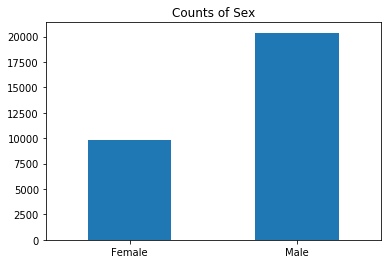

In [4]:
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

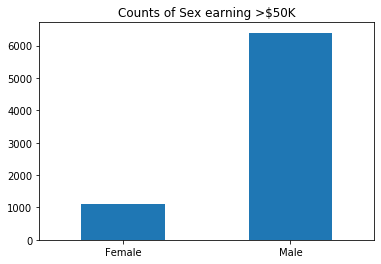

In [5]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Encode and Upload the Dataset

여기에서 훈련 및 테스트 데이터를 인코딩합니다. SageMaker Clarify에는 입력 데이터 인코딩이 필수는 아니지만 모델 학습에는 필요합니다.


In [6]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


"Female" 성 값은 0으로, "Male"은 1로 인코딩되었습니다.

In [7]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


마지막으로 데이터를 S3에 업로드합니다.

In [8]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

### Train XGBoost Model
#### Train Model

본 노트북은 SageMaker Clarify를 사용하는 방법의 확인이 목적이므로, 간단히 표준 XGBoost 모델을 사용하겠습니다. 

In [9]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2021-07-24 08:14:17 Starting - Starting the training job
2021-07-24 08:14:18 Starting - Launching requested ML instances........
2021-07-24 08:15:07 Starting - Preparing the instances for training.............
2021-07-24 08:16:16 Downloading - Downloading input data..
2021-07-24 08:16:28 Training - Downloading the training image......
2021-07-24 08:17:07 Training - Training image download completed. Training in progress....
2021-07-24 08:17:24 Uploading - Uploading generated training model
2021-07-24 08:17:31 Completed - Training job completed


#### Deploy Model

이제 SageMaker 모델을 생성합니다.

In [10]:
model_name = "DEMO-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'DEMO-clarify-model'

## Amazon SageMaker Clarify

예측용 모델이 정의되었습니다. 이제 SageMaker Clarify를 시작해보겠습니다.


In [11]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

### Detecting Bias

SageMaker Clarify는 다양한 메트릭을 사용하여 가능한 사전 및 사후 교육 편향을 감지하는 것을 도와줍니다.

#### Writing DataConfig and ModelConfig

`DataConfig` 객체는 데이터 I/O에 대한 몇 가지 기본 정보를 SageMaker Clarify에 전달합니다. 입력 데이터 세트를 찾을 위치, 출력을 저장할 위치, 타겟 컬럼(`label`), 헤더 이름 및 데이터 세트 유형을 지정합니다.


In [12]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

`ModelConfig` 객체는 훈련된 모델에 대한 정보를 전달합니다. 프로덕션 모델에 대한 추가 트래픽을 방지하기 위해 SageMaker Clarify는 분석작업 실행시 전용 엔드포인트를 설정하고 분석이 끝나면 삭제합니다.

* `instance_type`과 `instance_count`는 SageMaker Clarify의 처리 중에 모델을 실행하는 데 사용되는 인스턴스 유형과 인스턴스 수를 지정합니다. 본 예제의 테스트 데이터 세트는 작기 때문에 단일 표준 인스턴스로 실행하기에 충분합니다. 대규모의 복잡한 데이터 세트가 있는 경우 더 높은 인스턴스 유형을 사용하여 속도를 높이거나, 더 많은 인스턴스를 추가하여 Spark 병렬작업을 활성화할 수 있습니다.
* `accept_type`은 엔드포인트 응답(Response) 페이로드 형식을 나타내고 `content_type`은 엔드포인트에 대한 요청(Request)의 페이로드 형식을 나타냅니다.

In [13]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

`ModelPredictedLabelConfig` 예측의 포맷에 대한 정보를 제공합니다. XGBoost 모델은 샘플의 확률을 출력하므로 SageMaker Clarify는 엔드포인트를 호출한 다음 `probability_threshold`를 사용하여 편향 분석을 위해 확률을 이진 레이블로 변환합니다. 임계값 초과 예측은 레이블 값 1로 해석되고 레이블 값 0 이하이거나 같음으로 해석됩니다.


In [14]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

#### Writing BiasConfig

SageMaker Clarify는 민감한 컬럼(`facets`)이 무엇인지, 민감한 특성(`facet_values_or_threshold`)이 무엇인지, 긍정적인 예측결과(`label_values_or_threshold`)가 무엇인지에 대한 정보가 필요합니다. SageMaker Clarify는 `facet_values_or_threshold` 및 `label_values_or_threshold에` 대해 범주형 데이터와 연속형 데이터를 모두 처리할 수 있습니다. 본 예제에서는 범주형 데이터를 사용합니다.

우리는 `BiasConfig` API를 통하여 이 정보를 지정합니다. 여기에서 긍정적인 결과는 >$50,000의 수입을 받는 것이고 성별은 민감한 범주이며 여성 응답자는 민감한 그룹입니다. `group_name`은 Simpson의 역설과 관련하여 CDDL(Conditional Demographic Disparity in Labels) 및 CDDPL(Conditional Demographic Disparity in Predicted Labels) 측정을 위한 하위 그룹을 형성하는 데 사용됩니다.


In [15]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

#### Pre-training Bias

모델 학습이 발생하기 전에 데이터에 편향이 있을 수 있습니다. 훈련을 시작하기 전에 데이터에 편향이 있는지 검사하면 데이터 수집 단계에서의 격차를 감지하고 특성 엔지니어링에 정보를 제공하며 데이터가 반영할 수 있는 사회적 편향을 이해하는 데 도움이 될 수 있습니다.

사전 훈련 편향(Pre-training Bias) 메트릭을 계산하는 데는 훈련된 모델은 필요하지 않습니다.


#### Post-training Bias

훈련 후 편향(Post-training Bias) 메트릭을 계산하려면 훈련된 모델이 필요합니다.


편향되지 않은 훈련 데이터(편향 메트릭에 의해 측정된 공정성(fairness)에 의해 결정)일지라도 학습 후에 편향된 모델 예측을 초래할 수 있습니다. 편향의 발생은 하이퍼파라미터 선택을 포함한 여러 요인에 따라 달라집니다.

분석작업의 실행시 `run_pre_training_bias()` 또는 `run_post_training_bias()` 를 사용하여 로 개별적으로 편향을 분석할 수 있으며, 또는 아래처럼 `run_bias()`를 이용하여 이 둘을 동시에 실행할 수 있습니다.


In [16]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2021-07-24-08-23-36-197
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

#### Viewing the Bias Report

Sagemaker studio의 Experiment 탭에서 분석 결과를 볼 수 있습니다.


<img src="./recordings/bias_report.gif">

각 편향 메트릭에는 탐색할 수 있는 예제와 함께 자세한 설명이 있습니다.

<img src="./recordings/bias_detail.gif">

결과를 간단한 표로 요약할 수도 있습니다.

<img src="./recordings/bias_report_chart.gif">


SageMaker Studio 사용자가 아닌 경우 다음 S3 버킷에서 pdf, html 및 ipynb 형식의 편향 보고서에 액세스할 수 있습니다.

In [17]:
bias_report_output_path

's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

### Explaining Predictions

모델이 결정을 내린 이유에 대한 설명을 요구하는 비즈니스 요구와 입법 규정이 확대되고 있습니다. SageMaker Clarify는 SHAP를 사용하여 각 입력 특성(feature)이 최종 결정에 미치는 영향을 설명합니다.


커널 SHAP 알고리즘에는 Baseline(백그라운드 데이터 세트라고도 함)이 필요합니다. Baseline 데이터셋 유형은 `DataConfig`의 `dataset_type`과 동일해야 하며, Baseline 샘플에는 특성(feature)만 포함되어야 합니다. 정의에 따라, Baseline은 Baseline 데이터셋 파일에 대한 S3 URI 또는 리스트 형식으로 샘플을 직접 전달할 수 있습니다. 본 예제에서는 두번째 방식을 선택하여 테스트 데이터셋드의 첫번째 샘플을 리스트로 전달하였습니다. 

In [24]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [25]:
%%time
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2021-07-24-09-18-22-964
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMo

#### Viewing the Explainability Report

편향 보고서와 마찬가지로 Studio의 Experiment 탭에서 Explainability 보고서를 볼 수 있습니다.

<img src="./recordings/explainability_detail.gif">

Model Insights 탭에는 보고서 및 Model Insights에 대한 링크가 포함되어 있습니다.

SageMaker studio 사용자가 아닌 경우에는, 편향 보고서와 마찬가지로 다음 S3 버킷에서 이 보고서에 액세스할 수 있습니다.

In [21]:
explainability_output_path

's3://sagemaker-us-east-2-308961792850/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

#### Analysis of local explanations

데이터 세트의 단일 예에 대해 로컬 설명을 시각화할 수 있습니다. 또는 전역 설명을 위해 Kernel SHAP 알고리즘을 실행하여 얻은 결과를 사용할 수 있습니다.

출력 경로에 저장된 로컬 설명을 로드하고 단일 예제에 대한 설명(즉, 단일 기능이 모델 예측에 미치는 영향)을 시각화할 수 있습니다.


Example number: 111 
with model prediction: False

Feature values -- Label Target                 0
Age                   21
Workclass              2
fnlwgt            199915
Education             15
Education-Num         10
Marital Status         4
Occupation             7
Relationship           3
Ethnic group           4
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per week        40
Country               38
Name: 120, dtype: int64


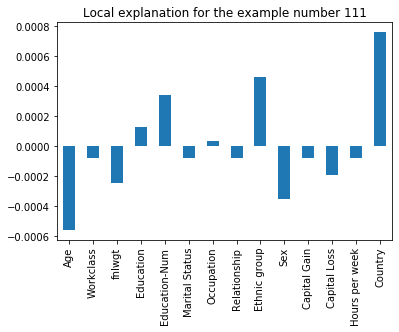

In [22]:
local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

### Clean Up

마지막으로 데모에서 설정하고 사용한 리소스를 정리하는 것을 잊지 마십시오.

In [ ]:
session.delete_model(model_name)

In [26]:
!pwd

/root/amazon-sagemaker-examples/sagemaker_processing/fairness_and_explainability
